In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2_13e27') #binary_cl2_old_best, binary_cl2_4

In [4]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 256, 'n_channels1_cnn': 400, 'n_channels2_cnn': 600, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f03d058a8b0>, <dataset.data.SmartNegAugment object at 0x7f03d058a820>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f03d058a940>, <dataset.data.SmartNegAugment object at 0x7f03d05a05e0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [5]:
#args_dict['policies_train'][0].height_probabilities

In [6]:
#args_dict['policies_train'][0].height_bins

In [7]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_test_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_test_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [8]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'test500.csv'))

In [9]:
assert test500.couples.isin(gene_pairs_test).all()

In [10]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'test_results500.csv'))

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.74      0.59      0.66     30810
           1       0.40      0.56      0.46     14569

    accuracy                           0.58     45379
   macro avg       0.57      0.58      0.56     45379
weighted avg       0.63      0.58      0.60     45379



In [11]:
original_res_shape = res.shape[0]
#take only big windows
treshold = 29
subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
res = res[res.id_sample.isin(subset.couples)]

perc = np.round((res.shape[0] / original_res_shape)*100, 2)
print(perc)

5.95


# PLOTS

### Log plots

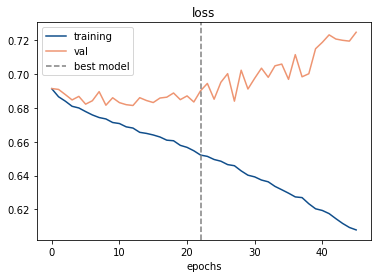

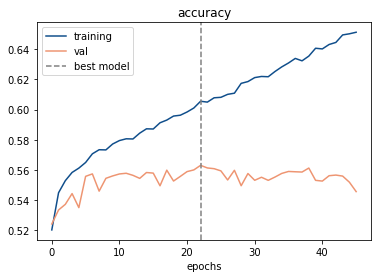

In [12]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [13]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

1    1598
0    1103
Name: prediction, dtype: int64


0    1578
1    1123
Name: ground_truth, dtype: int64


In [14]:
n_conf = 10

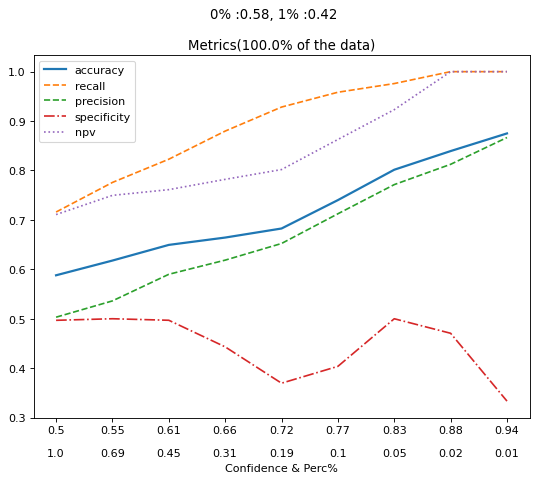

In [15]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

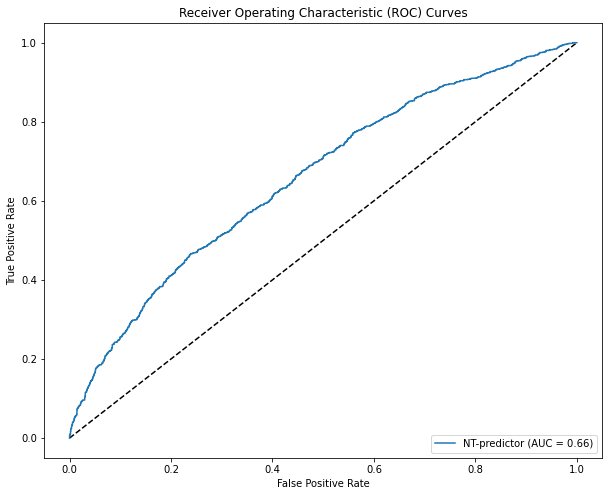

In [16]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

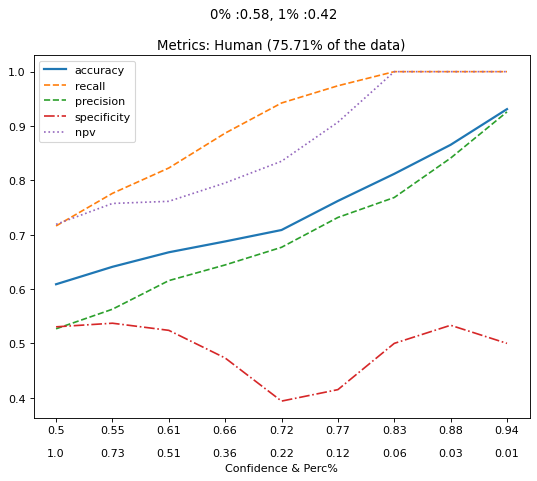

In [17]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

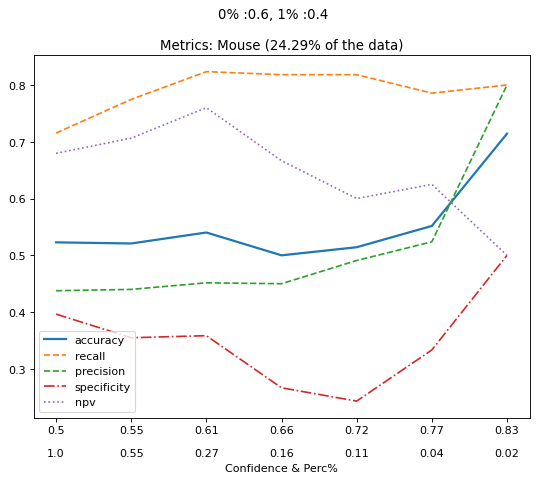

In [18]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

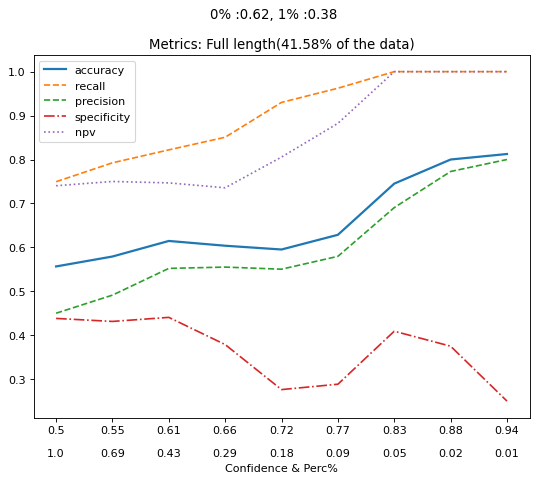

In [19]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [20]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [21]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.6

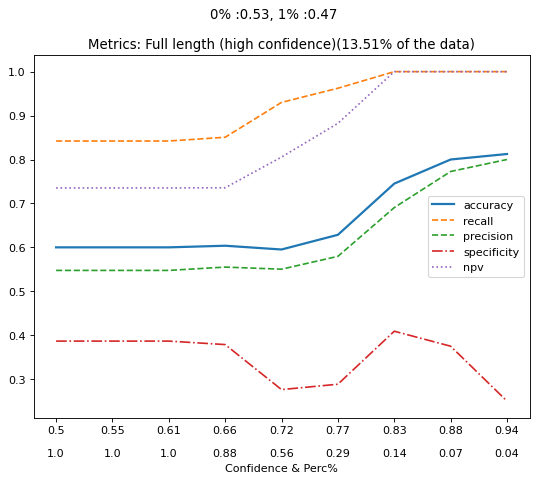

In [22]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [23]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

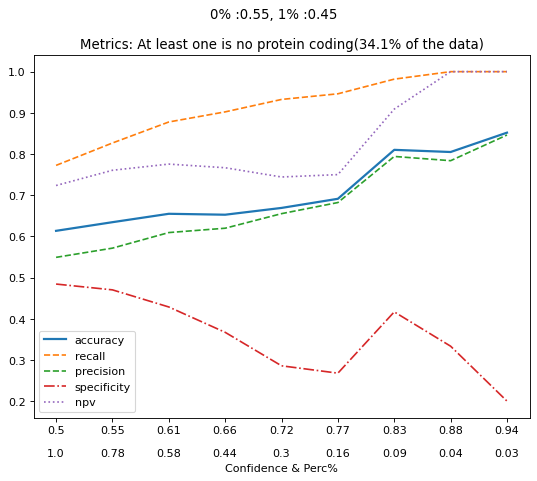

In [24]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

In [25]:
test = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))
print(test.interacting.value_counts())
test = test[['id_gene1_sample', 'id_gene2_sample']]

True     14569
False    14569
Name: interacting, dtype: int64


In [26]:
res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

1    1123
0     770
Name: ground_truth, dtype: int64

In [27]:
# subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt.txt")
# with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
#     subset_test_nt_sampled = pickle.load(fp)
    
# easypos_smartneg = res[res.id_sample.isin(subset_test_nt_sampled)]

0.6323296354992076


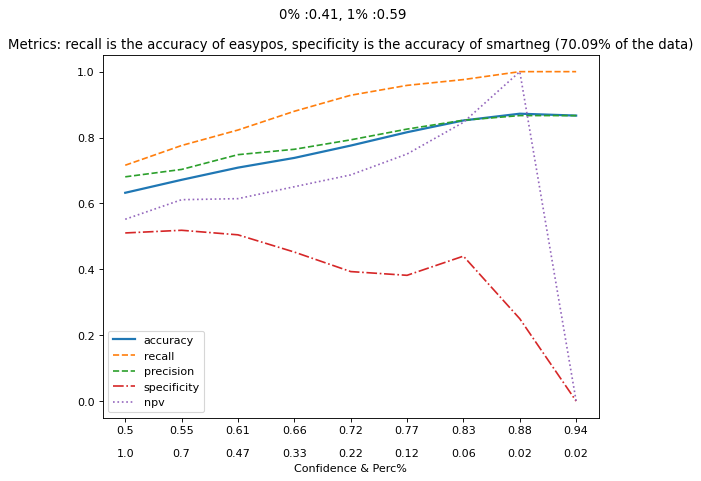

In [28]:
# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

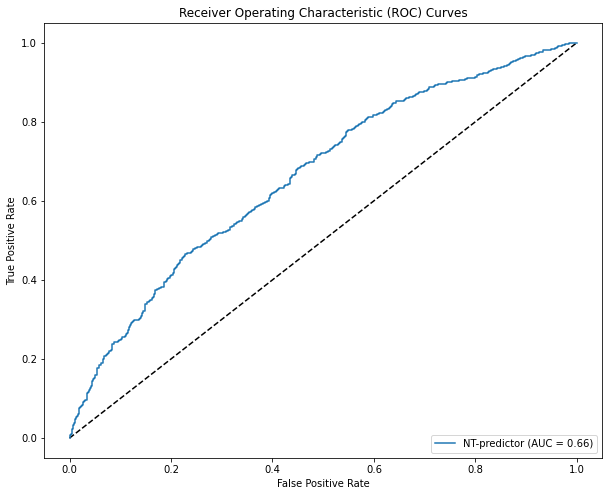

In [29]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

In [ ]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

In [ ]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

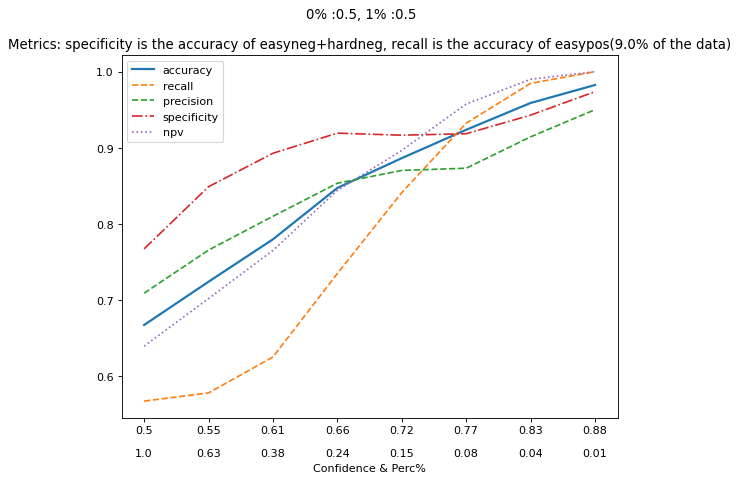

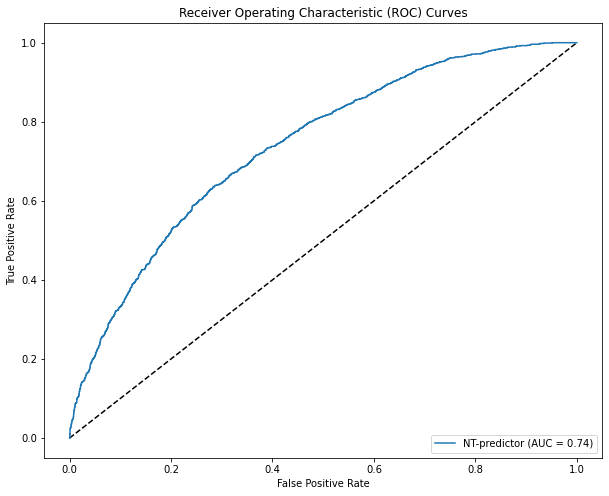

In [30]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

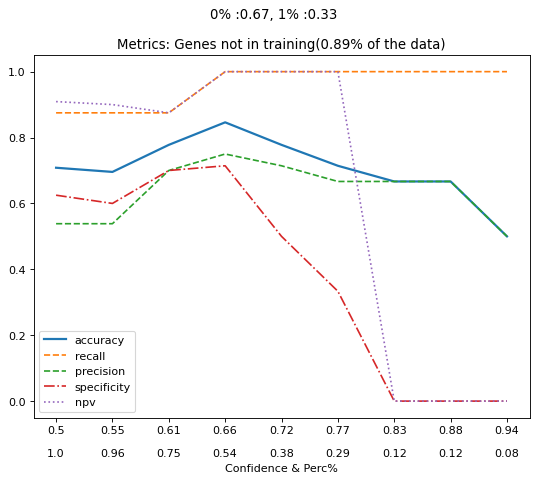

In [30]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

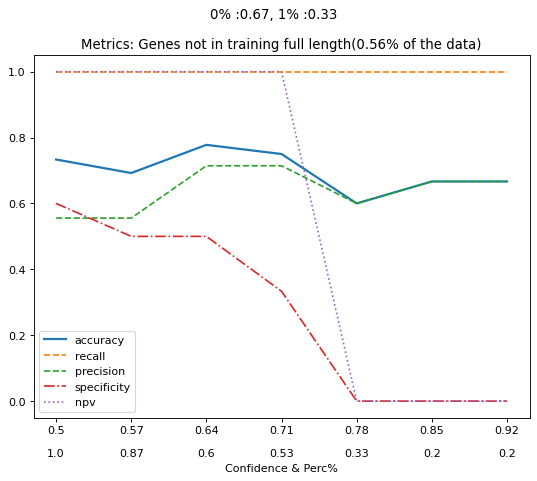

In [32]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

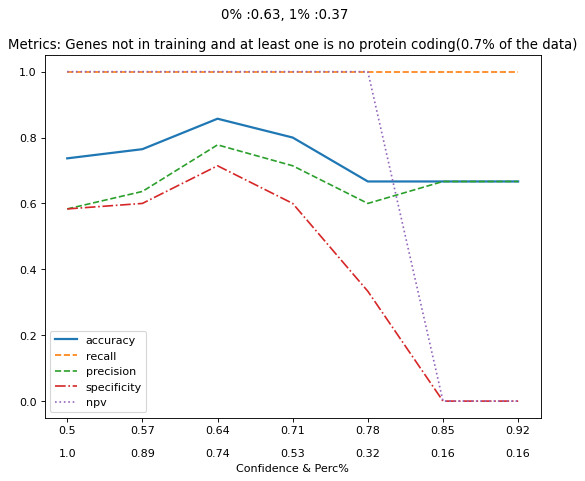

In [33]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

Real percentage is: 0.89%


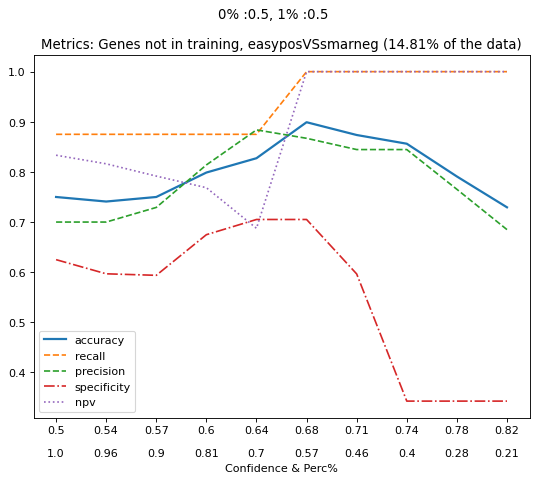

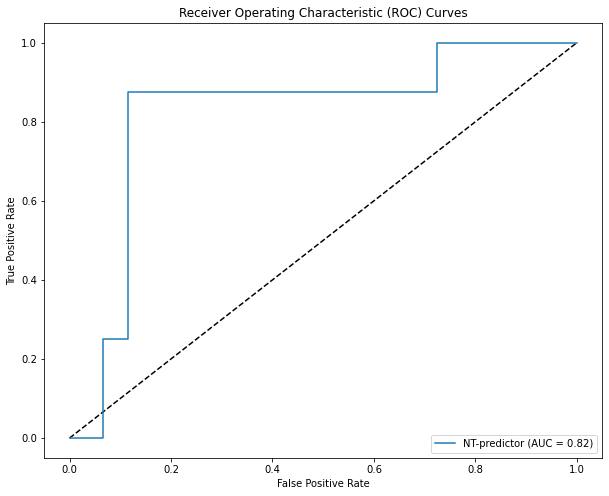

In [34]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
real_perc = np.round(not_in_train_epsn.shape[0]/res.shape[0]*100, 2)
print(f'Real percentage is: {real_perc}%')
toappend = []
for i in range(25):
    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]
    toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
not_in_train_epsn_balanced = pd.concat(toappend, axis = 0)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

Real percentage is: 0.59%


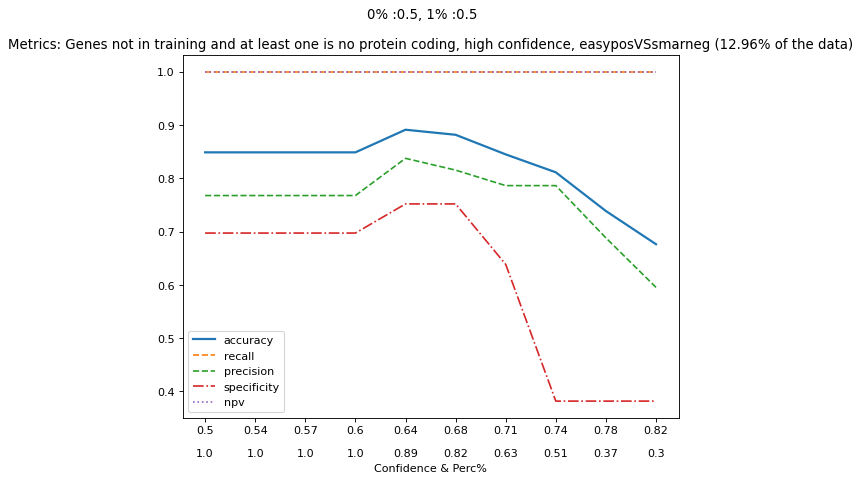

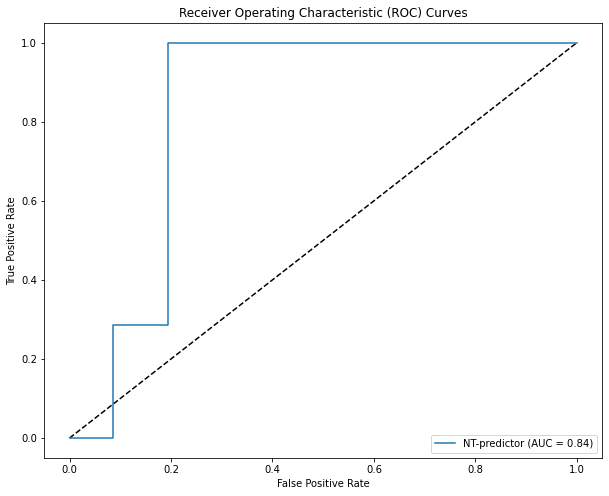

In [37]:
confidence_level = 0.6

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
real_perc = np.round(no_pc_no_train.shape[0]/res.shape[0]*100, 2)
print(f'Real percentage is: {real_perc}%')

toappend = []
for i in range(25):
    negs = no_pc_no_train[no_pc_no_train.ground_truth == 0]
    poss = no_pc_no_train[no_pc_no_train.ground_truth == 1]
    toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
no_pc_no_train = pd.concat(toappend, axis = 0)


obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

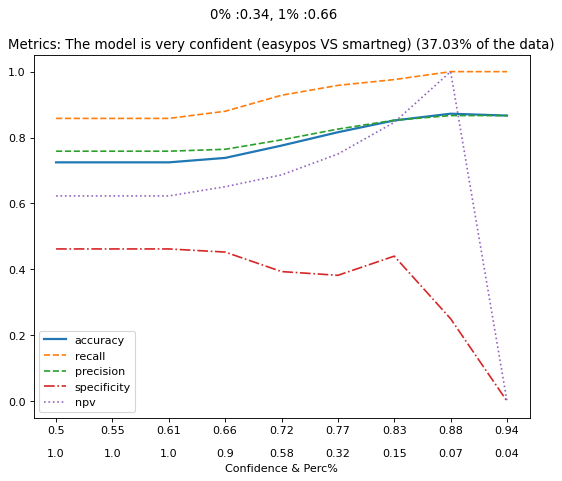

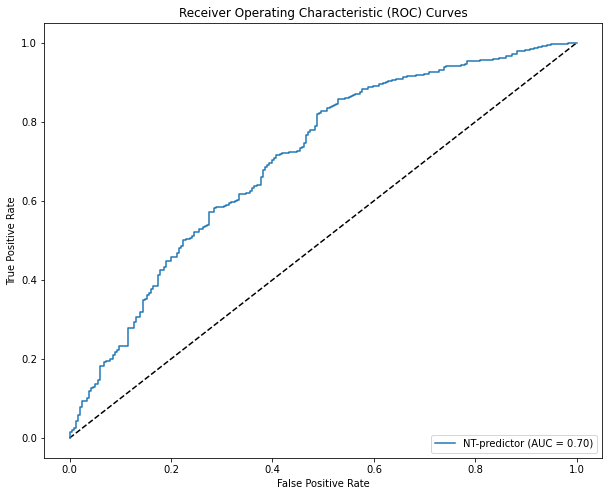

In [38]:
confidence_level = 0.65
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(high_prob_pairs, n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

Real percentage is: 0.67%


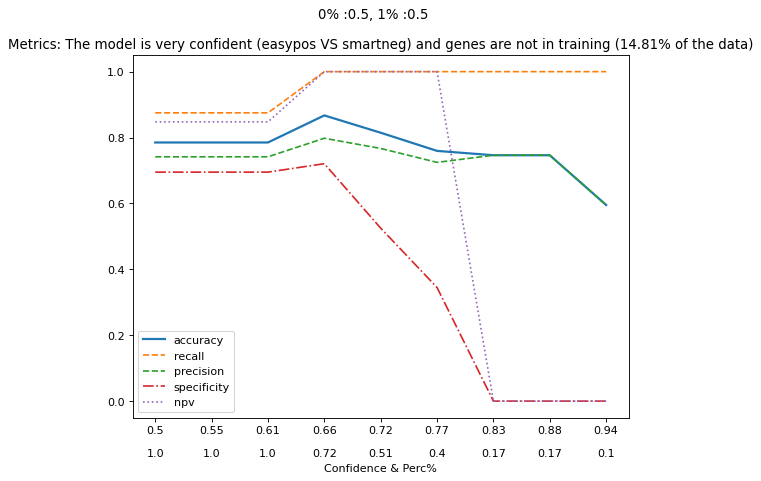

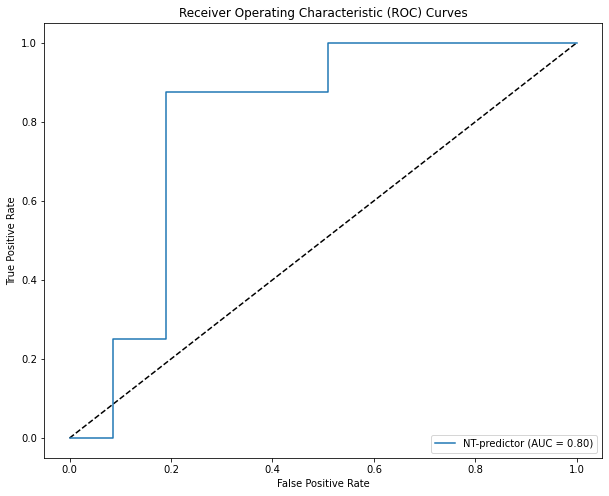

In [39]:
confidence_level = 0.6
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

real_perc = np.round(high_prob_pairs.shape[0]/res.shape[0]*100, 2)
print(f'Real percentage is: {real_perc}%')

toappend = []
for i in range(25):
    negs = high_prob_pairs[high_prob_pairs.ground_truth == 0]
    poss = high_prob_pairs[high_prob_pairs.ground_truth == 1]
    toappend.append(pd.concat([negs.sample(len(poss)), poss], axis = 0))
high_prob_pairs = pd.concat(toappend, axis = 0)

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


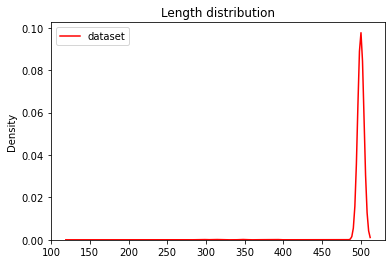

In [40]:
sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
plt.title(f'Length distribution')
plt.legend()

# Compare with INTARNA

In [41]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'test500', 'test.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [42]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [43]:
intarna.shape[0]

45379

In [44]:
res.shape[0]

2701

In [45]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [46]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.6580334049887047 0.5436925358151307


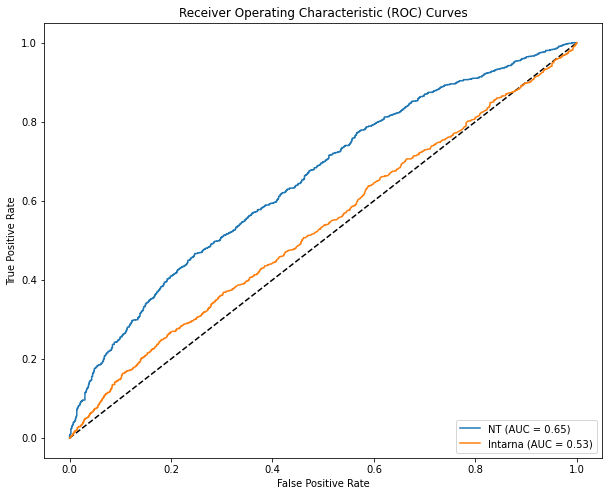

In [47]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

In [ ]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

1    1123
0     770
Name: ground_truth, dtype: int64


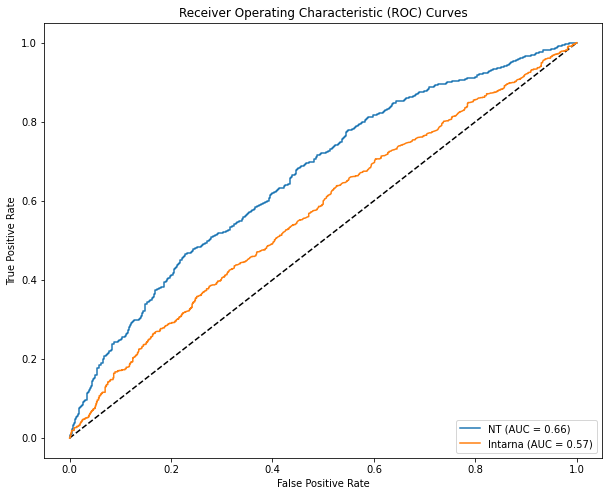

In [49]:
test = pd.read_csv(os.path.join(metadata_dir, f'test_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
print(easypos_smartneg.ground_truth.value_counts())

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


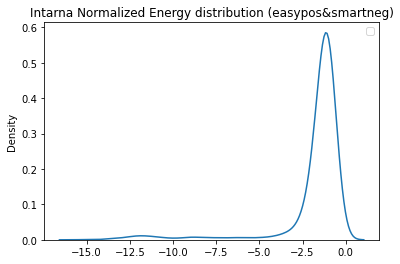

In [50]:
sns.kdeplot(list(easypos_smartneg.E_norm))
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

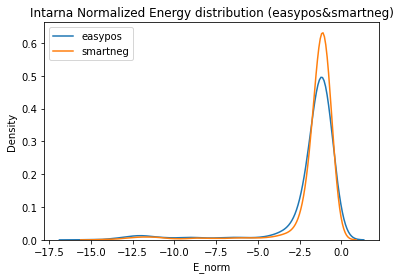

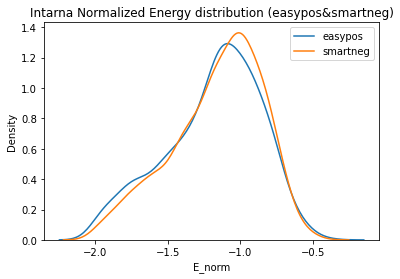

In [51]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [52]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  10.0 %


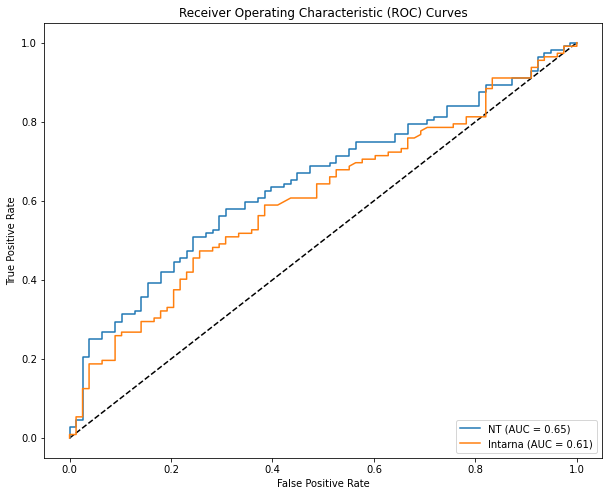

In [59]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.05)

perc of the total data:  25.8 %


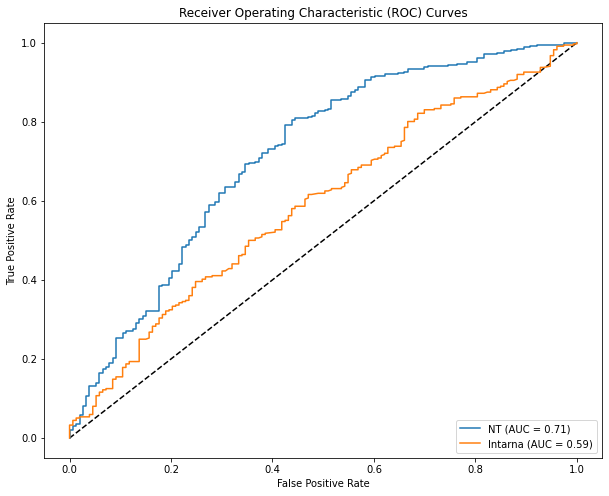

In [60]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

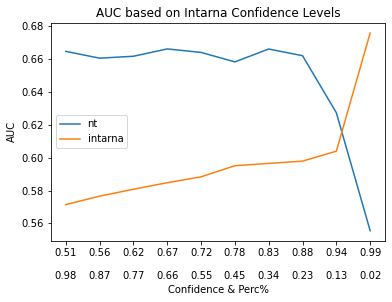

In [61]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

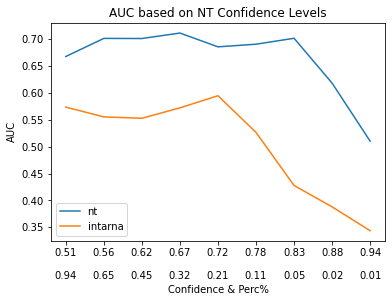

In [62]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

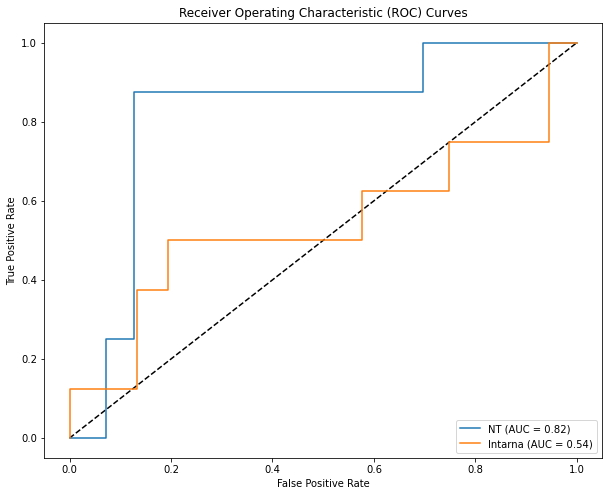

In [63]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [64]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [65]:
subset_where_disagree.ground_truth.value_counts()

1    336
0    153
Name: ground_truth, dtype: int64

Text(0.5, 0, 'Confidence & Perc%')

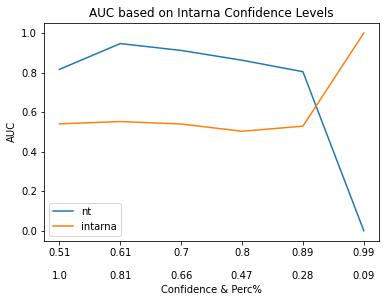

In [66]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'intarna', n_values = 6)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

In [67]:
confidence_space = np.linspace(0.51, 0.99, 6)
for i in range(6):
    treshold = 1-confidence_space[i]
    subset = not_in_train_epsn[
        (not_in_train_epsn.E_norm <= not_in_train_epsn.E_norm.quantile(treshold))|
        (not_in_train_epsn.E_norm >= not_in_train_epsn.E_norm.quantile(1-treshold))
    ]
fpr, tpr, _ = roc_curve(abs(1 - subset.ground_truth), subset.E_norm)
roc_auc = auc(fpr, tpr)
roc_auc

1.0

Text(0.5, 0, 'Confidence & Perc%')

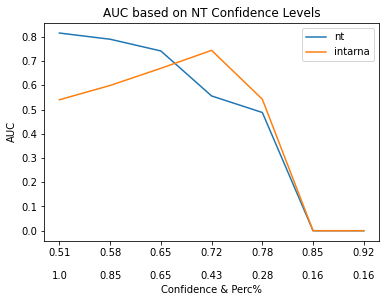

In [68]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(not_in_train_epsn, how = 'nt', n_values = 8)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Not in training genes

# Estimate bias due to genes degree

In [60]:
df_nt_train = df_nt[df_nt.couples.isin(gene_pairs_train)]

In [61]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [62]:
gene_count_train = obtain_gene_count_real(df_nt_train)

In [63]:
perc_list = []
pred_bias_list = []
acc_bias_list = []
diff_tresholds = np.linspace(0, 300, 10)
for diff_treshold in diff_tresholds:
    bias = res.merge(gene_count_train[['gene', 'diff']], how = 'left', left_on = 'g1', right_on = 'gene').rename({'diff':'diff1'}, axis = 1).drop('gene', axis = 1)
    bias = bias.merge(gene_count_train[['gene', 'diff']], how = 'left', left_on = 'g2', right_on = 'gene').rename({'diff':'diff2'}, axis = 1).drop('gene', axis = 1)
    bias = bias.fillna(0)   
    bias['diff_sum'] = bias['diff1'] + bias['diff2']
    bias['diff_sign'] = (bias['diff_sum'] > 0).astype(int)
    bias = bias[(bias['diff_sum'] > diff_treshold)|(bias['diff_sum'] <-diff_treshold)]

    perc = np.round(bias.shape[0]/res.shape[0] * 100, 2)
    pred_bias = (bias.prediction == bias['diff_sign']).sum()/bias.shape[0] * 100
    pred_bias = np.round(pred_bias, 2)
    acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100
    acc_bias = np.round(acc_bias, 2)
    print(f'in the {perc}% of the data, the prediction equal to the sum of sign is {pred_bias} %, and the accuracy of those predictions is {acc_bias}%')
    perc_list.append(perc)
    pred_bias_list.append(pred_bias)
    acc_bias_list.append(acc_bias)

in the 75.62% of the data, the prediction equal to the sum of sign is 52.67 %, and the accuracy of those predictions is 56.96%
in the 2.18% of the data, the prediction equal to the sum of sign is 83.28 %, and the accuracy of those predictions is 66.57%
in the 1.49% of the data, the prediction equal to the sum of sign is 86.98 %, and the accuracy of those predictions is 67.16%
in the 1.0% of the data, the prediction equal to the sum of sign is 92.95 %, and the accuracy of those predictions is 70.93%
in the 0.59% of the data, the prediction equal to the sum of sign is 97.41 %, and the accuracy of those predictions is 71.11%
in the 0.52% of the data, the prediction equal to the sum of sign is 98.3 %, and the accuracy of those predictions is 67.66%
in the 0.52% of the data, the prediction equal to the sum of sign is 98.3 %, and the accuracy of those predictions is 67.66%
in the 0.52% of the data, the prediction equal to the sum of sign is 98.3 %, and the accuracy of those predictions is 67

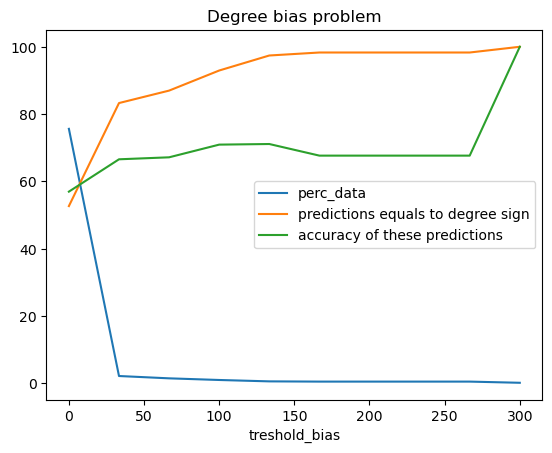

In [64]:
plt.title('Degree bias problem')
plt.plot(diff_tresholds, perc_list, label = 'perc_data')
plt.plot(diff_tresholds, pred_bias_list, label = 'predictions equals to degree sign')
plt.plot(diff_tresholds, acc_bias_list, label = 'accuracy of these predictions')
plt.xlabel('treshold_bias')
plt.legend()
plt.show()

In [65]:
diff_treshold = 5
genes_problematic_list = list(gene_count_train[(gene_count_train['diff'] > diff_treshold)|(gene_count_train['diff'] < -diff_treshold)].gene)

In [66]:
print('# of problematic genes: ', len(genes_problematic_list))

perc = np.round(res[(res.g1.isin(genes_problematic_list))|(res.g2.isin(genes_problematic_list))].shape[0]/res.shape[0] * 100, 2)

print('% of data affected from these genes: ', perc)

for problematic_gene in genes_problematic_list:
    gene_sign = bool(gene_count_train[gene_count_train.gene == problematic_gene]['diff'].iloc[0] > 0)
    bias = res[(res.g1 == problematic_gene)|(res.g2 == problematic_gene)]
    perc = np.round(bias.shape[0]/res.shape[0] * 100, 2)
    pred_bias = (bias.prediction == gene_sign).sum()/bias.shape[0] * 100
    pred_bias = np.round(pred_bias, 2)
    acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100
    acc_bias = np.round(acc_bias, 2)
    if perc>0.9:
        print(f'in the {perc}% of the data, the prediction equal to the sum of sign is {pred_bias} %, and the accuracy of those predictions is {acc_bias}%')

# of problematic genes:  554
% of data affected from these genes:  10.88


/tmp/ipykernel_535316/3921201605.py:11: RuntimeWarning: invalid value encountered in long_scalars
  pred_bias = (bias.prediction == gene_sign).sum()/bias.shape[0] * 100
/tmp/ipykernel_535316/3921201605.py:13: RuntimeWarning: invalid value encountered in long_scalars
  acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100


in the 1.44% of the data, the prediction equal to the sum of sign is 95.57 %, and the accuracy of those predictions is 53.13%


# XAI

In [68]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=256, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=256, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
      (1): ReLU()
    )
    (dropout_layers): ModuleList(
      (0): Dropout(p=0.01, inplace=False)
      (1): Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(256, 400, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(400, 600, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool

In [70]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500.csv'))

In [71]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [72]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0056
iou_value_tr: 0.0056
iou_value_rand: 0.0027


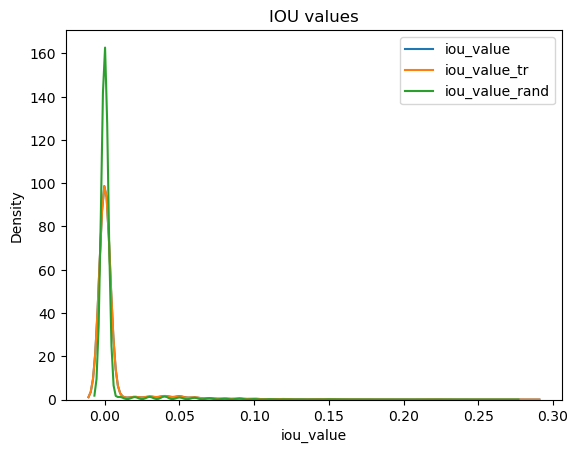

intensity: 0.258
intensity_tr: 0.1209
intensity_rand: 0.5


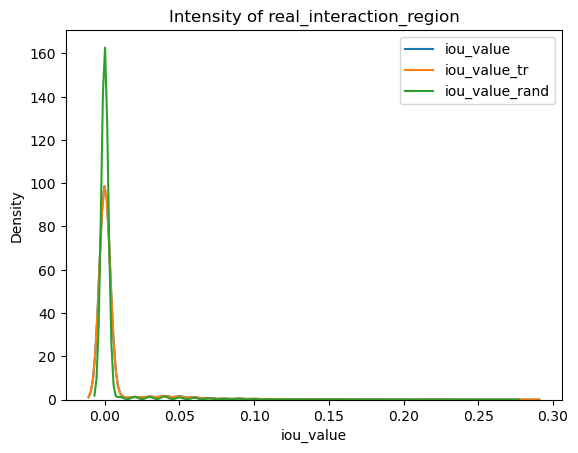

euclidean: 0.477
euclidean_rand: 0.5325
euclidean_bbox_tr: 0.4774


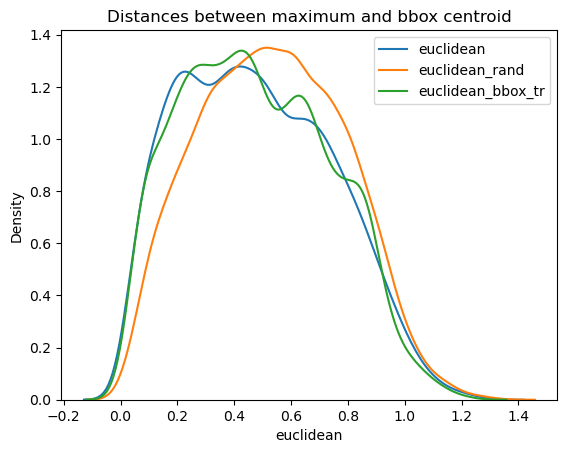

cos_sim: 0.05
cos_sim_tr: 0.04
cos_sim_rand: 0.04


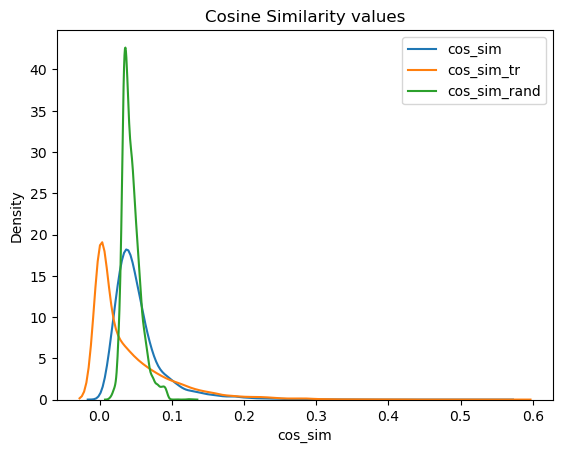

In [73]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [74]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.3628
euclidean_rand: 0.722


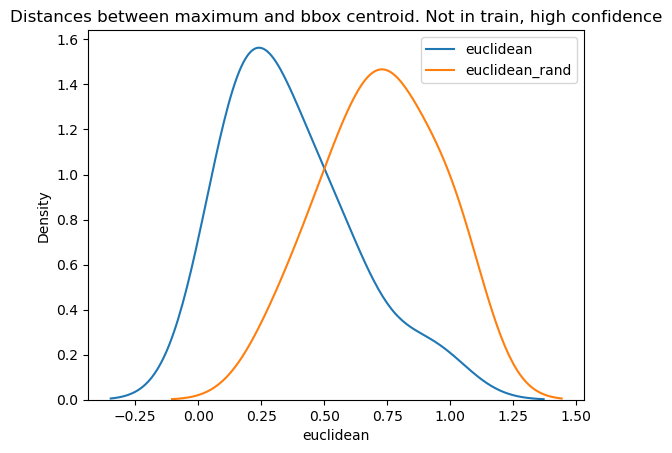

In [75]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [76]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.4545
euclidean_rand: 0.5331


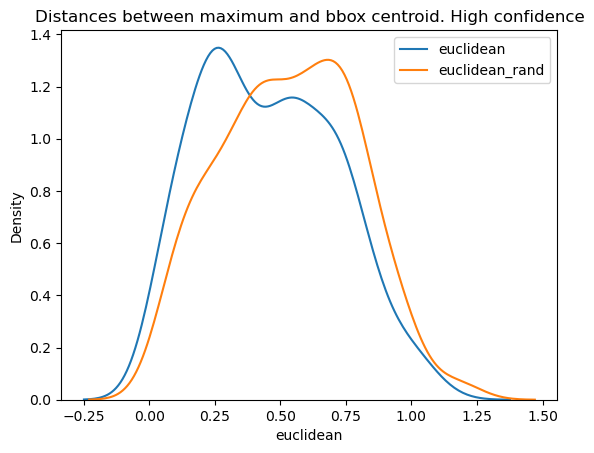

In [77]:
gradcam_results = xai[(xai.probability>0.75)&(xai.probability<0.79)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

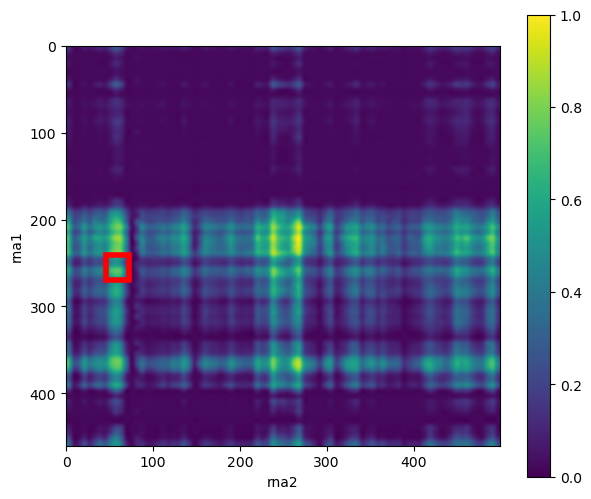

In [78]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query.sample(1))

Not in training

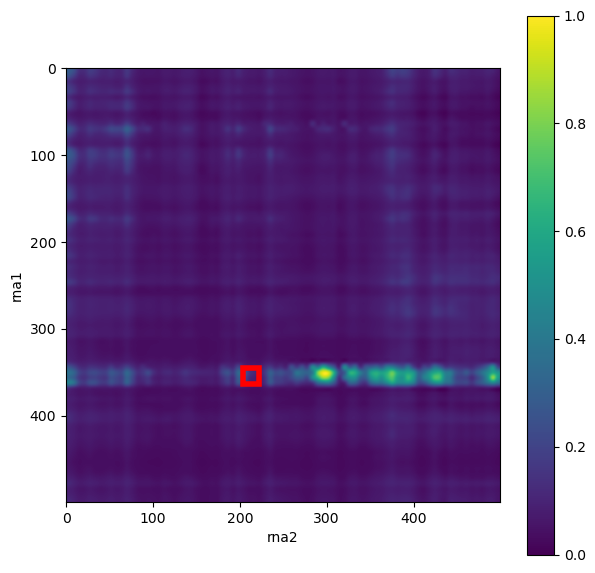

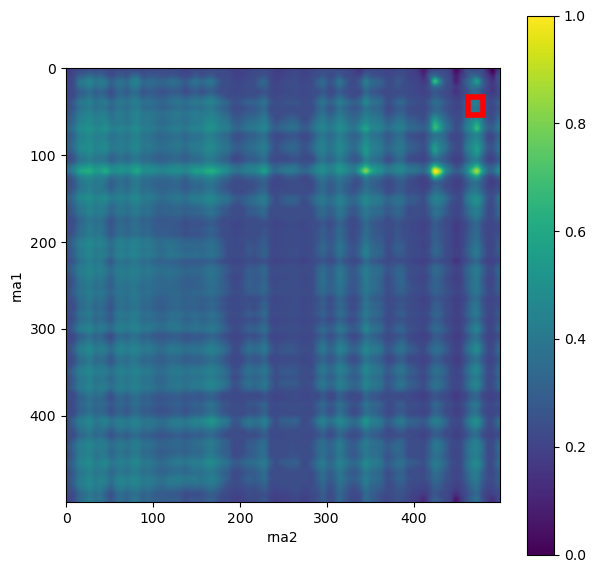

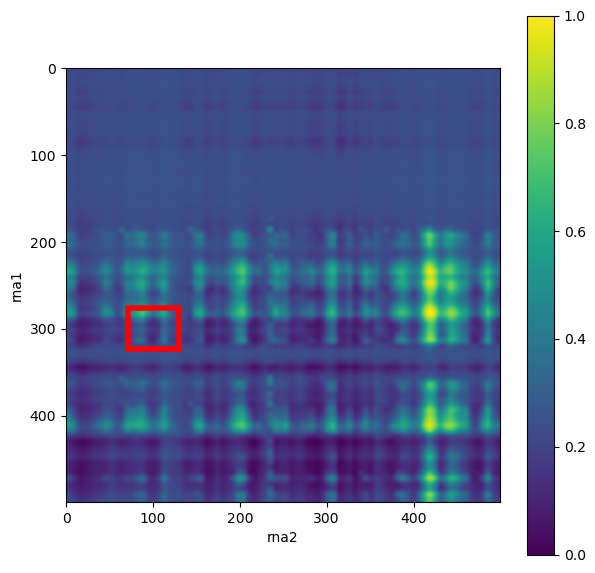

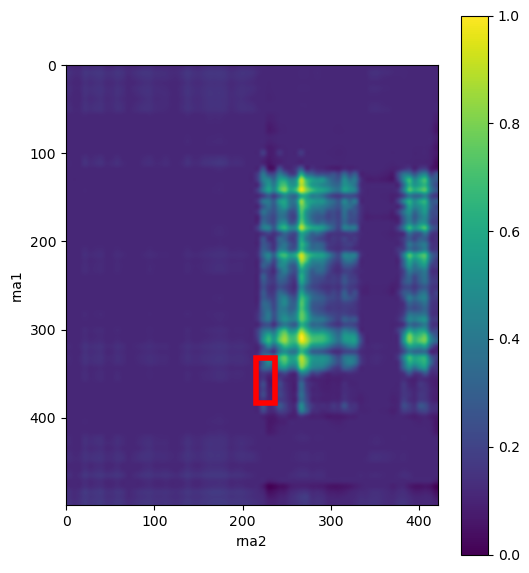

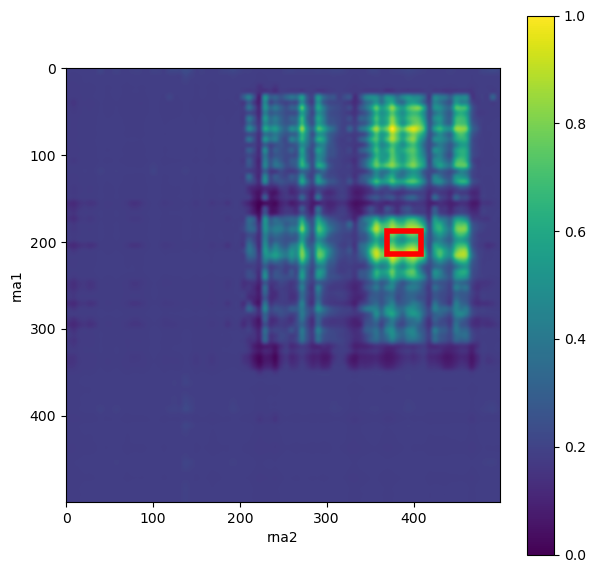

In [79]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(5))

High confidence not in train

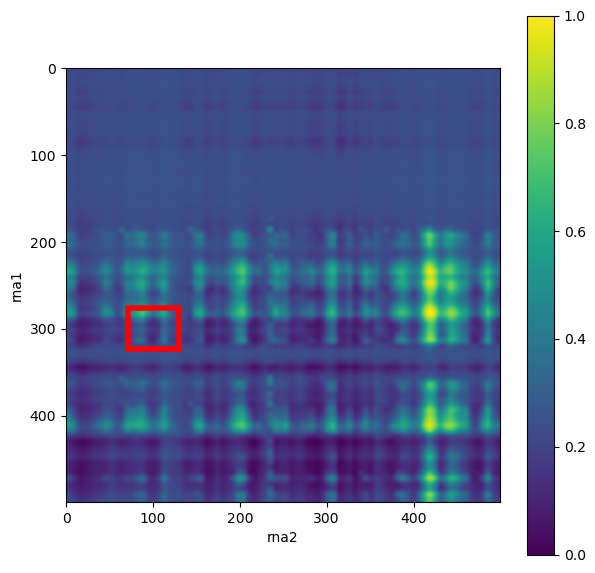

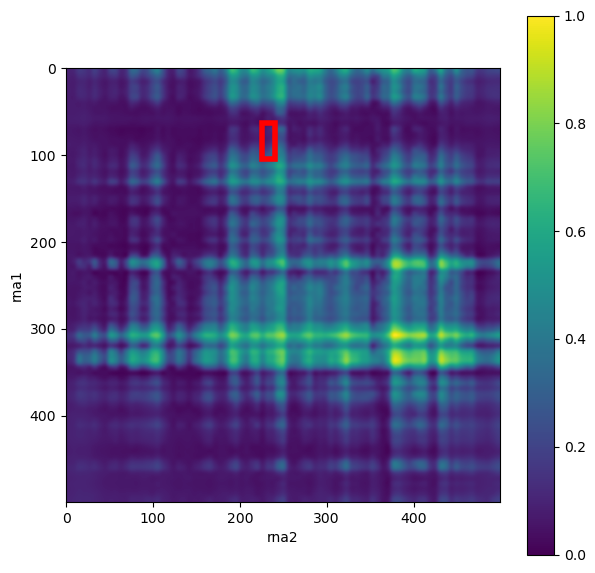

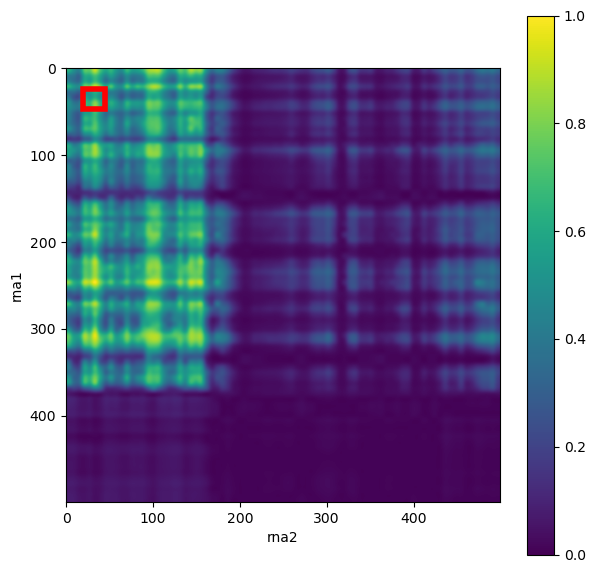

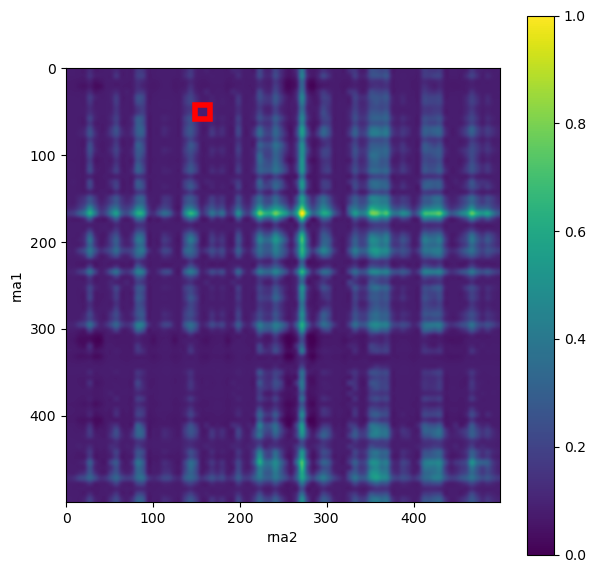

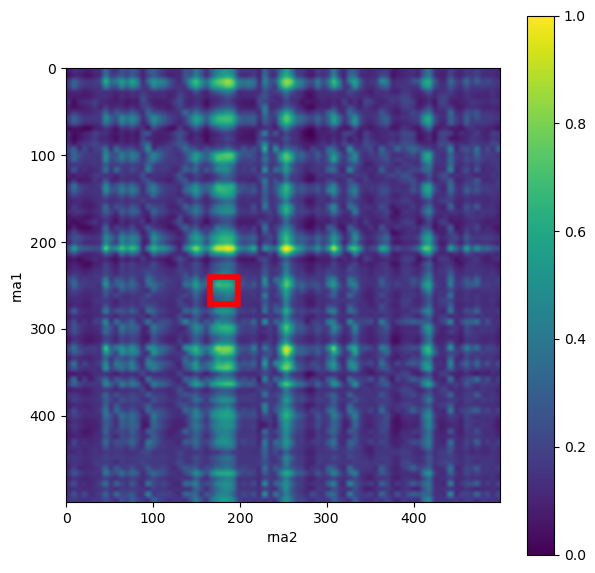

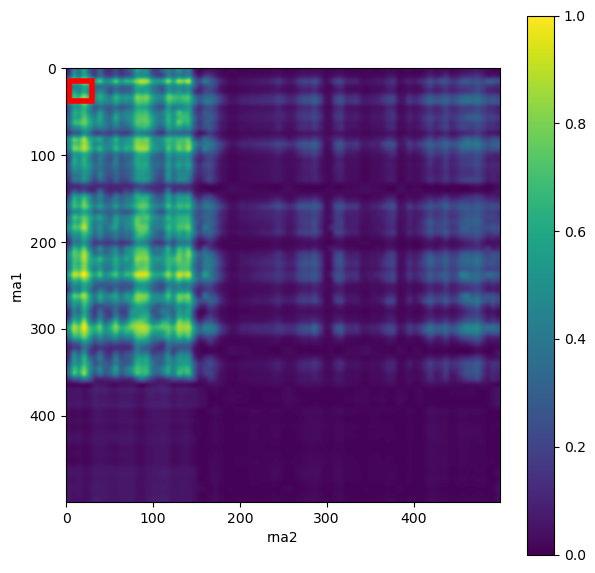

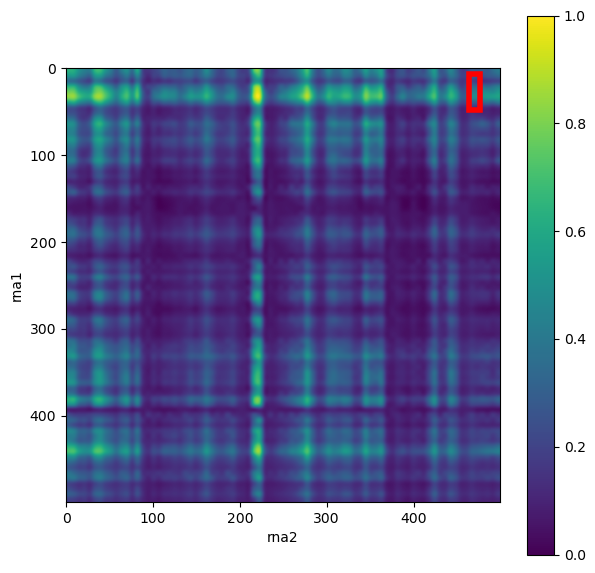

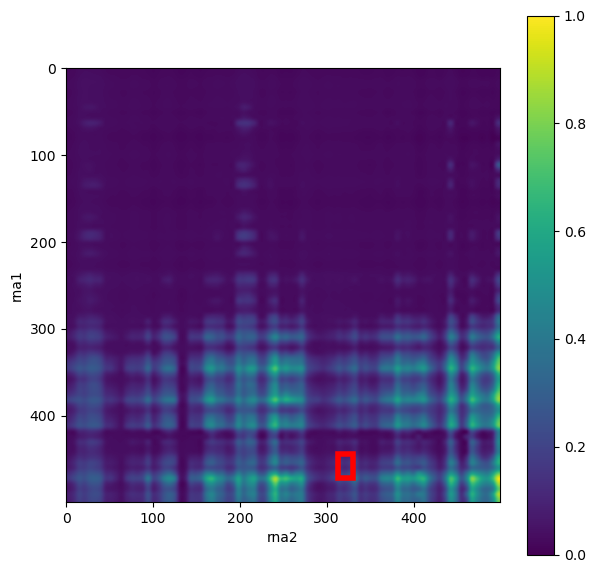

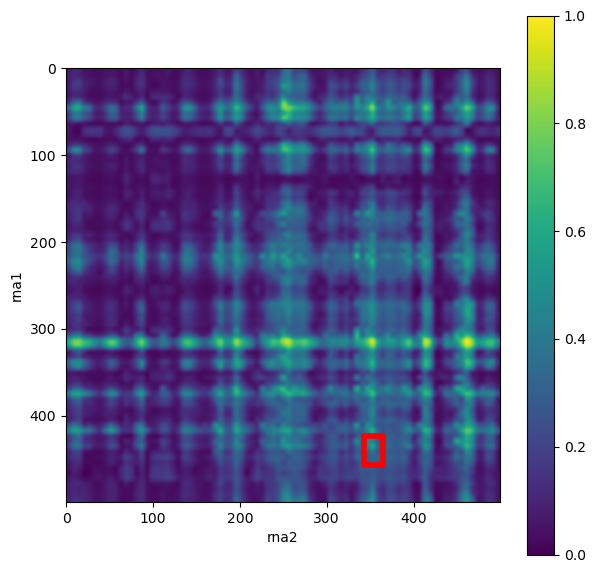

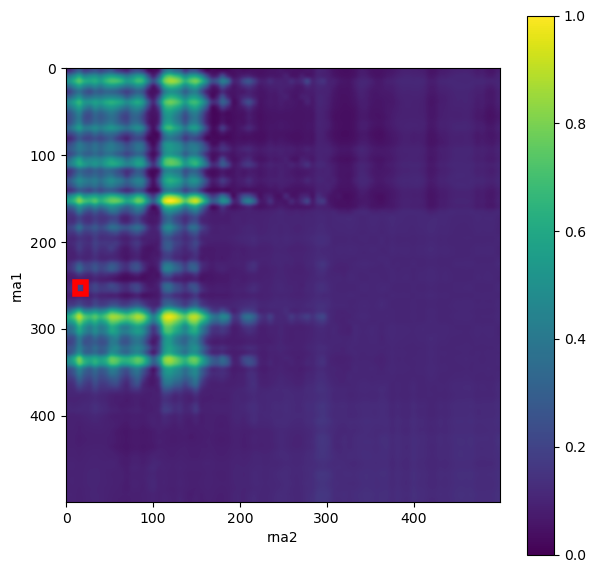

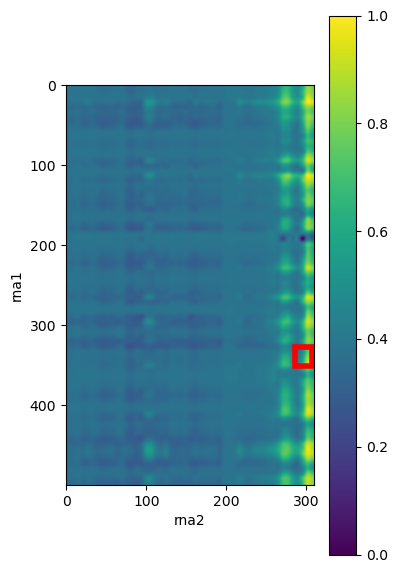

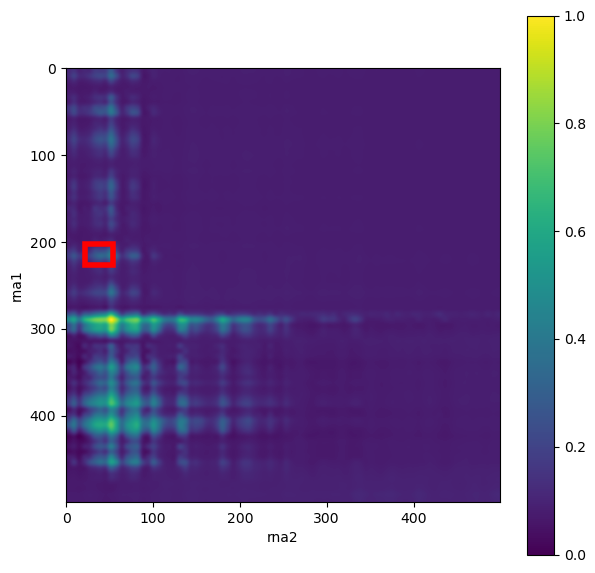

In [80]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.7)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(25))

False Negatives

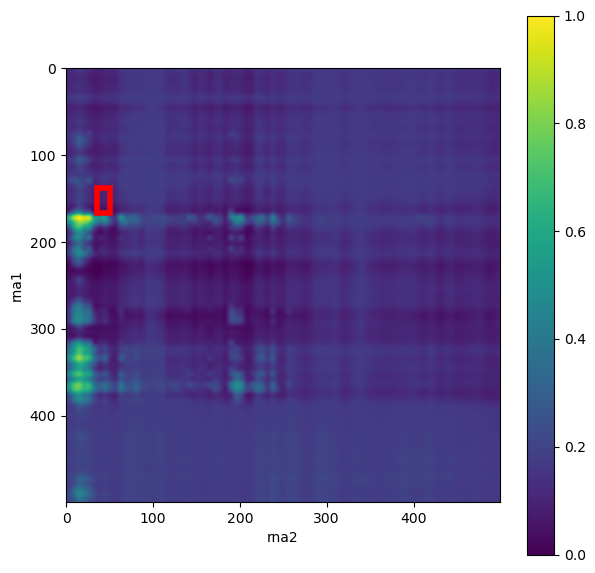

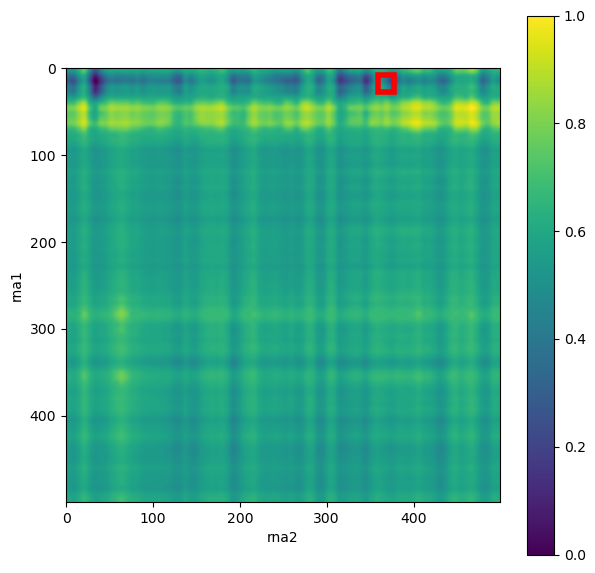

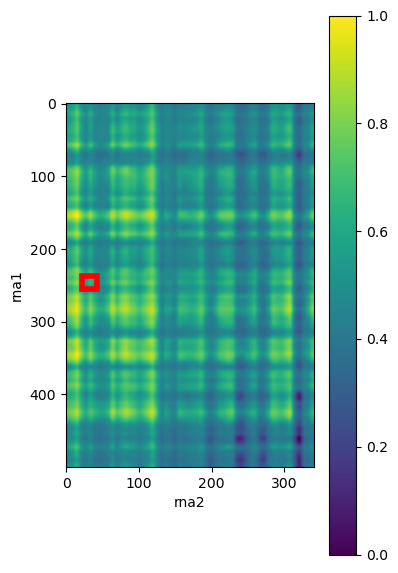

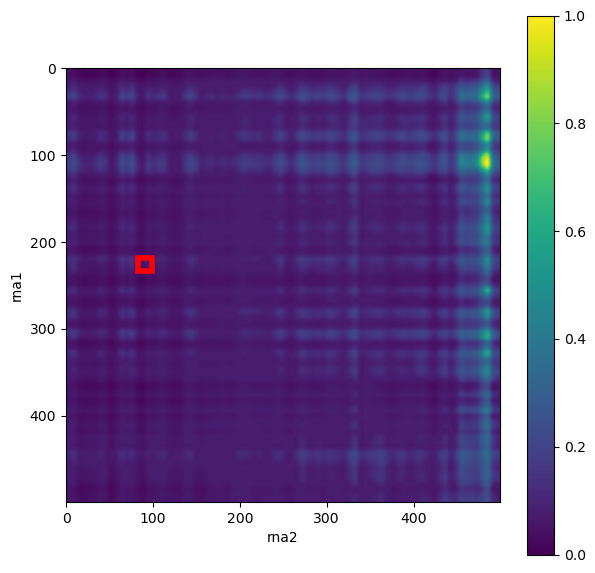

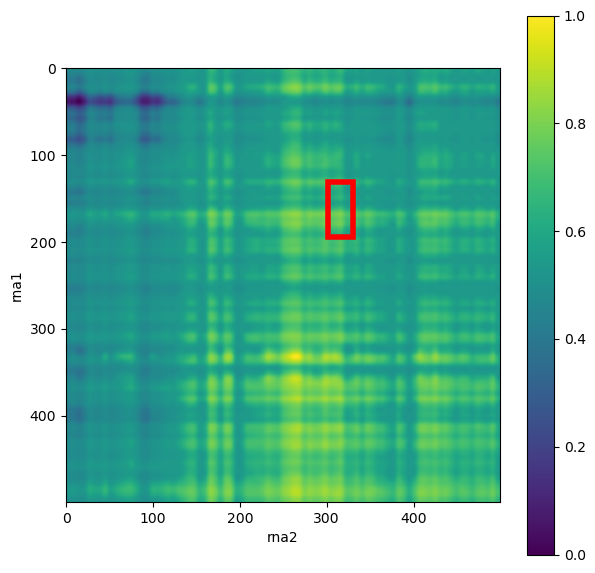

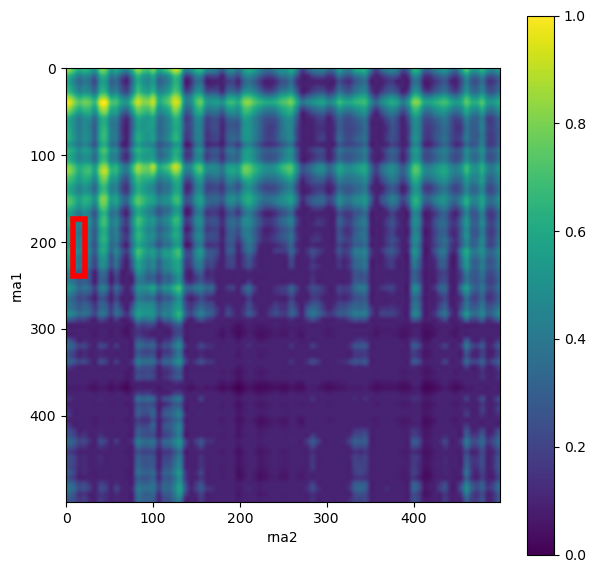

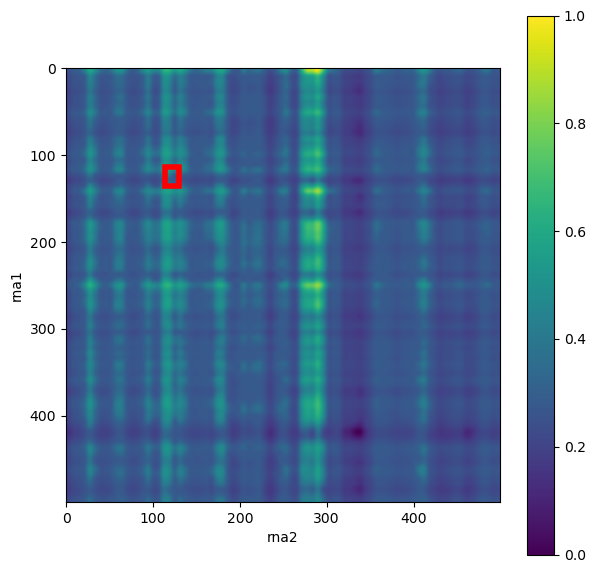

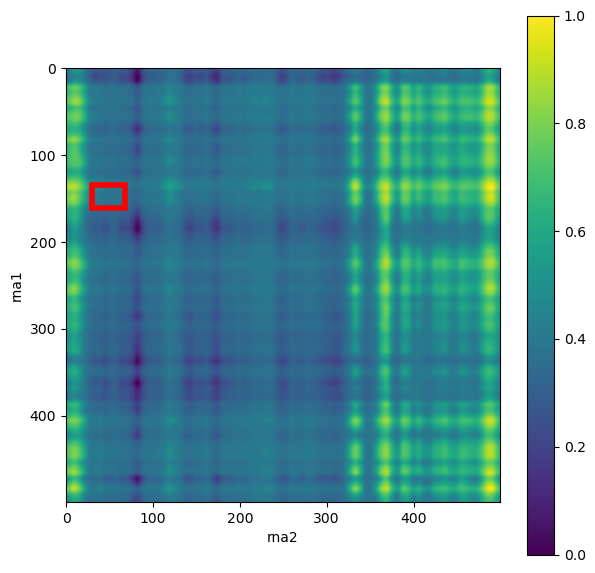

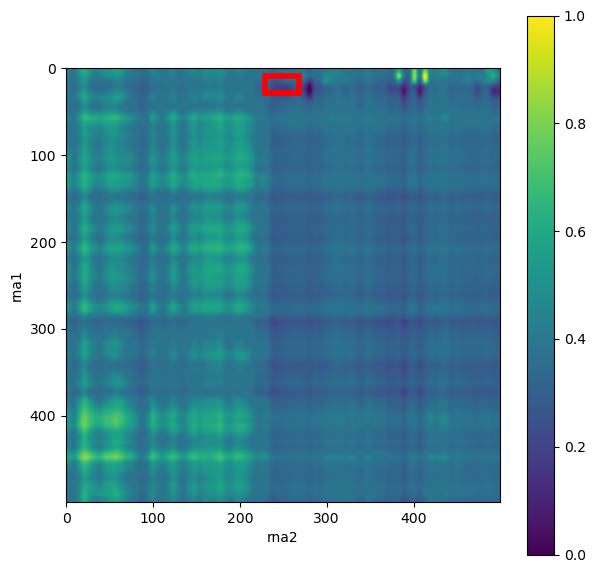

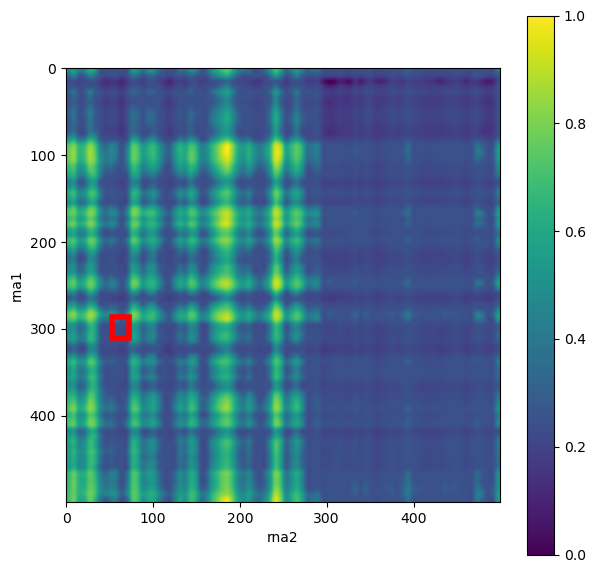

In [81]:
gradcam_results = xai
gradcam_results = gradcam_results[(gradcam_results.probability<0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(10))

False Negatives, not in train, almost 0.5

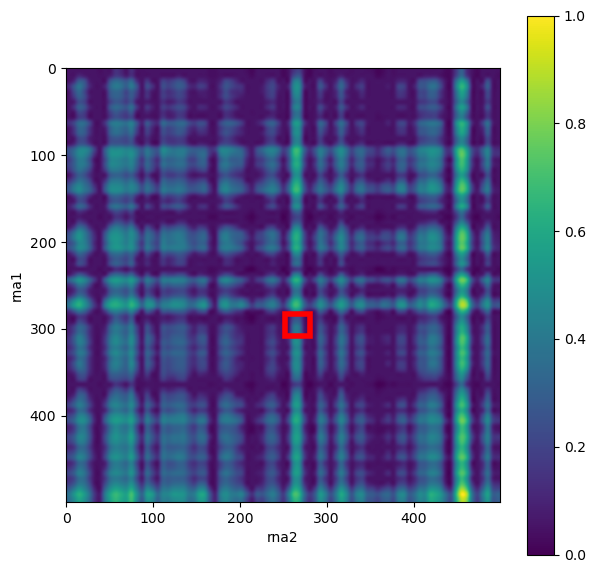

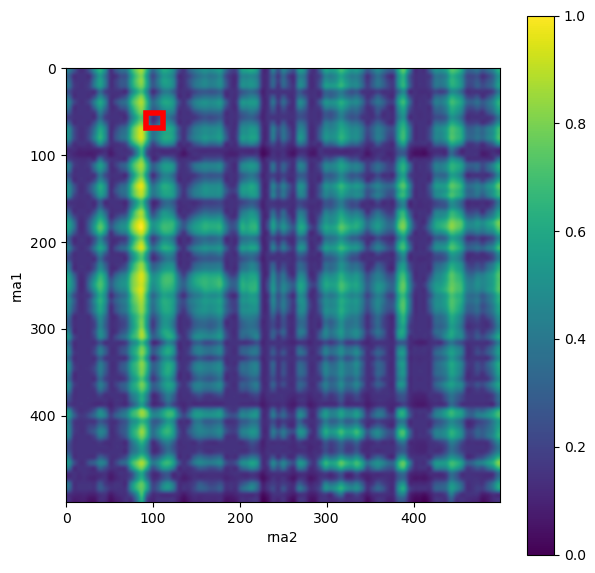

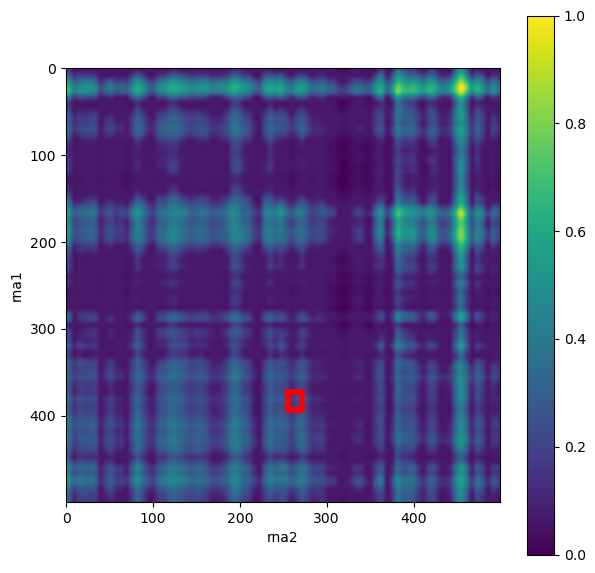

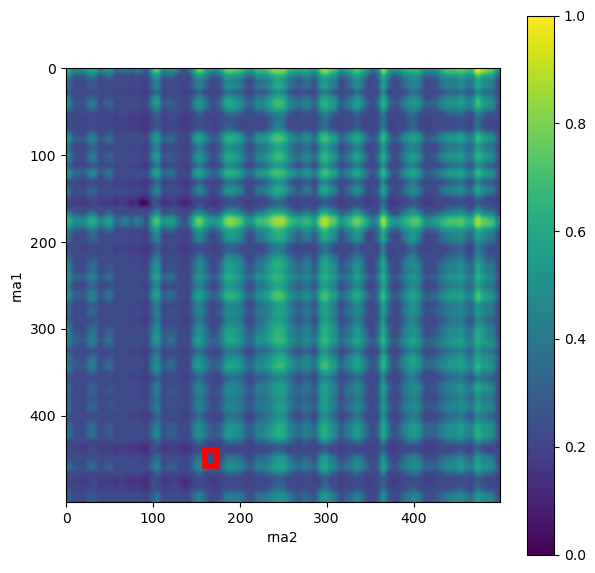

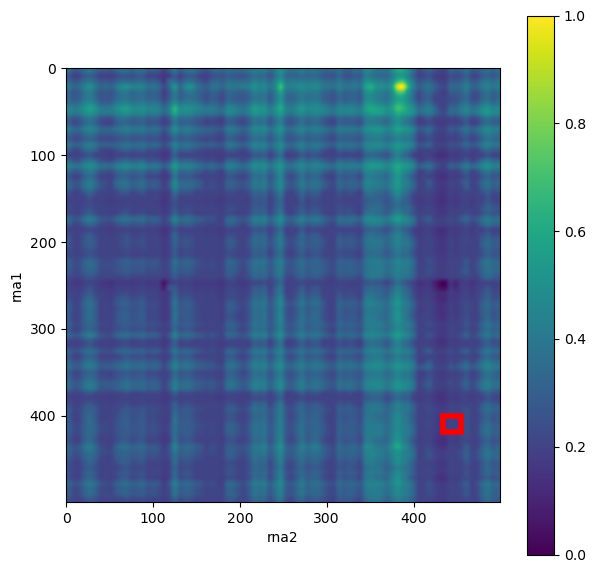

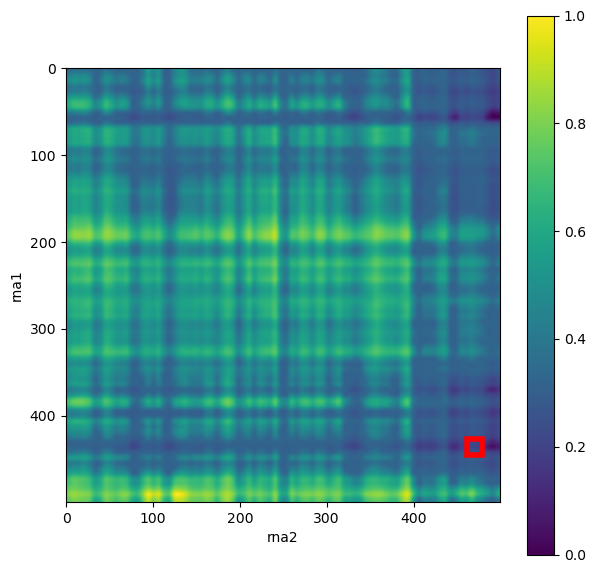

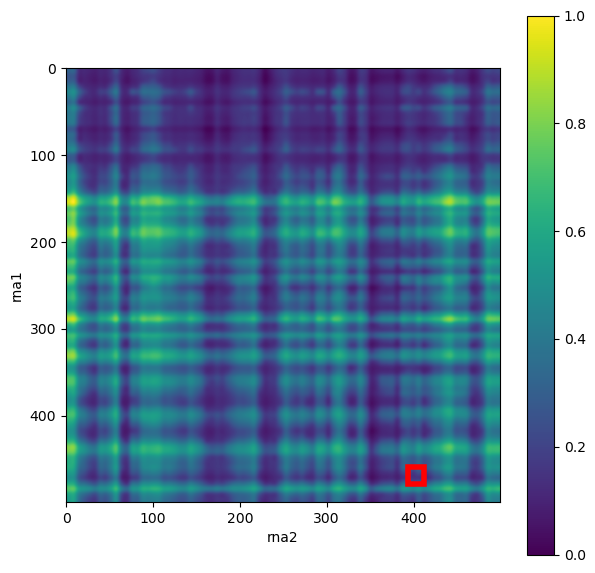

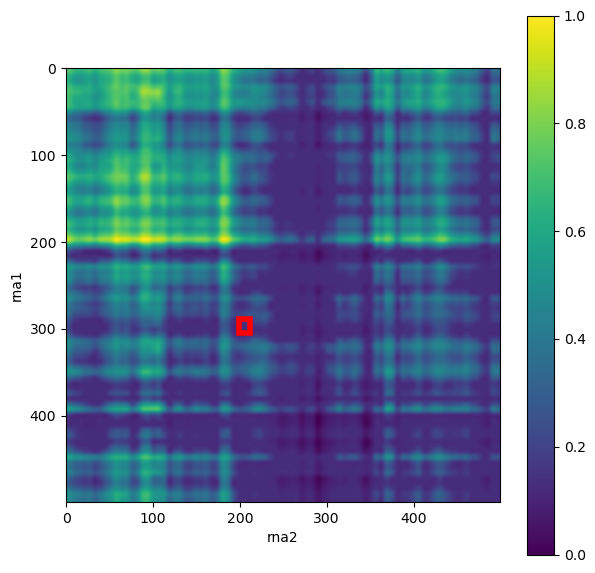

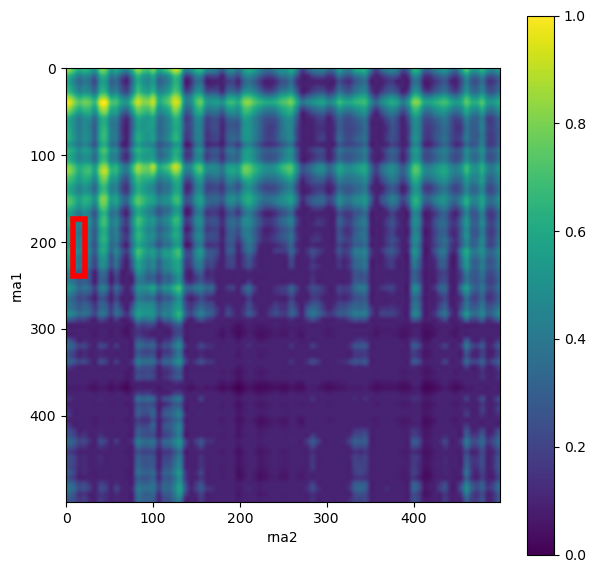

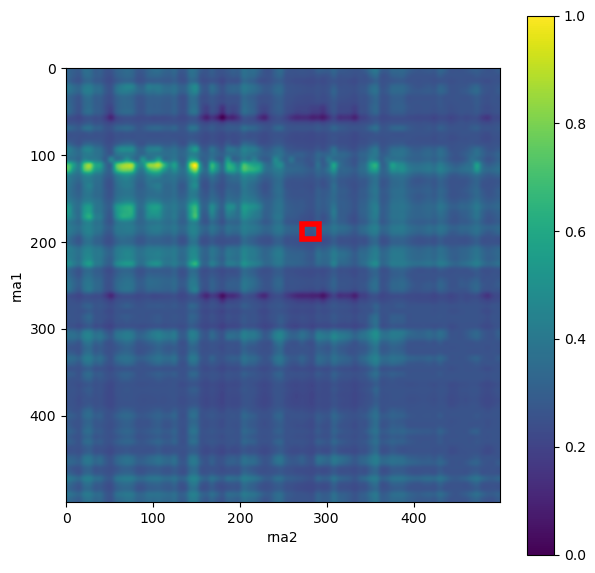

In [82]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability<0.5)&((gradcam_results.probability>0.48))]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(10))